In [1]:
import xscen as xs
from xscen.config import CONFIG, load_config

import xarray as xr
import numpy as np

from matplotlib import pyplot as plt
import xclim as xc
from matplotlib import gridspec
import cartopy.crs as ccrs

import spirograph.matplotlib as sp # this library is now called figanos.
sp.utils.set_mpl_style('ouranos')


load_config('../configuration/paths_ESPO-G_j.yml', '../configuration/config_ESPO-G_RDRS.yml', verbose=(__name__ == '__main__'), reset=True)
pcat = xs.ProjectCatalog(CONFIG['paths']['project_catalog'])
tdd = CONFIG['tdd']

INFO:xscen.config:Updated the config with ../configuration/paths_ESPO-G_j.yml.
INFO:xscen.config:Updated the config with ../configuration/config_ESPO-G_RDRS.yml.



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:142: UserWarning: Attribute "long_name" not found.


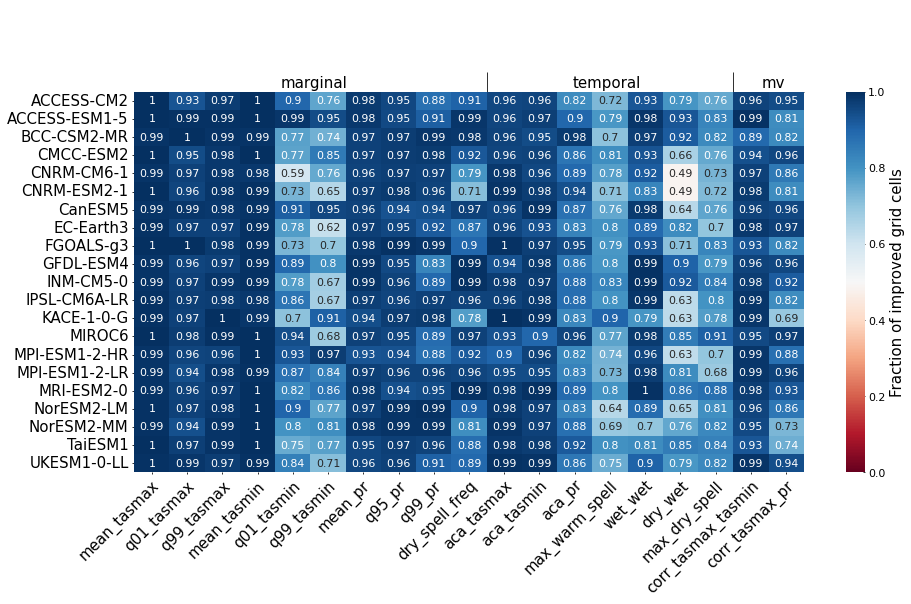

In [ ]:
#assemble all improved into 1 dataset
dict_hm = pcat.search(processing_level='off-diag-improved', domain= 'Nelson-Churchill', experiment='ssp370').to_dataset_dict()
dict_hm= {ds.attrs['cat:source']:ds for name,ds in dict_hm.items()}
ds_merge=xs.diagnostics.measures_improvement_2d(dict_hm)

# select the right order
# ordered list of properties
order = [
        'mean_tasmax','q01_tasmax', 'q99_tasmax', 'mean_tasmin','q01_tasmin','q99_tasmin',
    'mean_pr','q95_pr','q99_pr','dry_spell_freq', 
    'aca_tasmax', 'aca_tasmin','aca_pr',
         'maximum_length_of_warm_spell','wet_wet_transition', 'dry_wet_transition', 'maximum_length_of_dry_spell',
        'corr_tasmax_tasmin','corr_tasmax_pr',
        ]
# name I want to show up on plot
better_name = [
        'mean_tasmax','q01_tasmax', 'q99_tasmax', 'mean_tasmin','q01_tasmin','q99_tasmin',
    'mean_pr','q95_pr','q99_pr','dry_spell_freq', 
    'aca_tasmax', 'aca_tasmin','aca_pr',
         'max_warm_spell','wet_wet', 'dry_wet', 'max_dry_spell',
        'corr_tasmax_tasmin','corr_tasmax_pr',
        ]
# put in the right order
ds_merge= ds_merge.sel(properties=order, realization = np.sort(ds_merge.realization.values))
# change the name
ds_merge['properties']=better_name

ax=sp.heatmap(ds_merge, fig_kw={'figsize':(15,7)},divergent=0.5 , plot_kw={'vmin': 0, 'annot':True})
ax.set_xlabel("") # get rid of labels
ax.set_ylabel("")
plt.xticks(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


y=1.025
plt.annotate(r"marginal",fontsize=15,xy=(0.26, y), xycoords='figure fraction')
plt.annotate(r"temporal",fontsize=15,xy=(0.53, y), xycoords='figure fraction')
plt.annotate(r"mv",fontsize=15,xy=(0.705, y), xycoords='figure fraction')
ax2 = plt.gca().secondary_xaxis('top')
ax2.tick_params(axis='x',length=20, direction="out")
ax2.set_xticks([10,17])
plt.setp(ax2.get_xticklabels(), visible=False)


#cb = plt.colorbar()
ax.collections[-1].colorbar.set_label(label='Fraction of improved grid cells',size=15)
plt.savefig(f"imp_Nelson-Churchill.png", bbox_inches='tight')

In [35]:
#load all properties from ref, sim, scen
import copy
def maps(option_id, option_region, option_var):
    "Load properties and measures and plot them."
    
    # get data from catalogue
    prop_ref = pcat.search( processing_level=['diag-ref-prop*', 'diag_ref_prop'], domain=option_region, variable=option_var).to_dask()[option_var]
    prop_sim = pcat.search(id= option_id, processing_level='diag-sim-prop*', domain=option_region, variable=option_var).to_dask()[option_var]
    prop_scen = pcat.search(id= option_id, processing_level='diag-scen-prop*', domain=option_region, variable=option_var).to_dask()[option_var]
    meas_sim_prop = pcat.search(id=option_id, processing_level='diag-sim-meas*', domain=option_region, variable=option_var).to_dask()[option_var]
    meas_scen_prop = pcat.search(id=option_id, processing_level='diag-scen-meas*', domain=option_region, variable=option_var).to_dask()[option_var]
    
    
    #transpose
    if 'corr_' in option_var:
        prop_ref=prop_ref.transpose()
        prop_sim=prop_sim.transpose()
        prop_scen=prop_scen.transpose()
        meas_sim_prop=meas_sim_prop.transpose()
        meas_scen_prop=meas_scen_prop.transpose()
        # force the right cbar
        prop_ref.name= prop_ref.name+ " pr"
        prop_sim.name=prop_sim.name+ " pr"
        prop_scen.name=prop_scen.name+ " pr"
        meas_sim_prop.name=meas_sim_prop.name+ " pr"
        meas_scen_prop.name=meas_scen_prop.name+ " pr"
    
    prop_long_name=prop_sim.attrs['long_name'] 
    meas_long_name=meas_sim_prop.attrs['long_name'] 
    # change units
    if prop_ref.attrs['units']=='kg m-2 s-1':
        prop_ref = xc.core.units.convert_units_to(prop_ref, 'mm d-1', context='hydro')
        prop_sim = xc.core.units.convert_units_to(prop_sim, 'mm d-1', context='hydro')
        prop_scen = xc.core.units.convert_units_to(prop_scen, 'mm d-1', context='hydro')
        meas_sim_prop = xc.core.units.convert_units_to(meas_sim_prop, 'mm d-1', context='hydro')
        meas_scen_prop = xc.core.units.convert_units_to(meas_scen_prop, 'mm d-1', context='hydro')
        
    if prop_ref.attrs['units']=='K':
        prop_ref = xc.core.units.convert_units_to(prop_ref, 'degC')
        prop_sim = xc.core.units.convert_units_to(prop_sim, 'degC')
        prop_scen = xc.core.units.convert_units_to(prop_scen, 'degC')
        
    #set colormap
    maxi_prop = max(prop_ref.max().values, prop_scen.max().values, prop_sim.max().values)
    mini_prop = min(prop_ref.min().values, prop_scen.min().values, prop_sim.min().values)
    maxi_meas = float(max(abs(meas_scen_prop).max().values, abs(meas_sim_prop).max().values))

    #plot
    fig = plt.figure(figsize=(15, 8))
    map_proj = ccrs.RotatedPole(pole_longitude=87.59703063964844,
                          pole_latitude=31.758316040039062,
                         )
    gs = gridspec.GridSpec(4, 3)
    ax0= fig.add_subplot(gs[1:3,0],projection=map_proj)
    ax1= fig.add_subplot(gs[:2,1],projection=map_proj)
    ax2= fig.add_subplot(gs[:2,2],projection=map_proj)
    ax3= fig.add_subplot(gs[2:,1],projection=map_proj)
    ax4= fig.add_subplot(gs[2:,2],projection=map_proj)

    plot_kw_prop=dict(add_colorbar=False, vmin=mini_prop,vmax=maxi_prop)
    plot_kw_meas=dict(add_colorbar=False, vmin=-maxi_meas,vmax=maxi_meas)

    features={ 'lakes':{'scale':'110m', 'edgecolor':'black', 'facecolor':'none'},'coastline':{'scale':'50m'}}
    #plot
    # deep copy until bug is fix TODO
    sp.gridmap(prop_ref, ax=ax0, plot_kw=plot_kw_prop, features=copy.deepcopy(features))
    sp.gridmap(prop_sim, ax=ax1, plot_kw=plot_kw_prop, features=copy.deepcopy(features))
    sp.gridmap(prop_scen, ax=ax3, plot_kw=plot_kw_prop, features=copy.deepcopy(features))
    sp.gridmap(meas_sim_prop, ax=ax2, plot_kw=plot_kw_meas,divergent=0, features=copy.deepcopy(features))
    sp.gridmap(meas_scen_prop, ax=ax4, plot_kw=plot_kw_meas,divergent=0, features=copy.deepcopy(features))

    #prop colorbar
    fig.subplots_adjust(bottom=0.1)
    cbar_ax = fig.add_axes([0.15, 0.01, 0.45, 0.03])
    cb1=fig.colorbar(ax0.get_children()[0], cax=cbar_ax,orientation='horizontal')
    cb1.set_label(label=f"{prop_long_name} ({prop_sim.attrs['units']})",size=15)
    cb1.ax.tick_params(axis='x', direction='out')
    cb1.outline.set_visible(False)
    
    #meas colorbar
    fig.subplots_adjust(bottom=0.1)
    cbar_ax = fig.add_axes([0.68, 0.01, 0.25, 0.03])
    cb2=fig.colorbar(ax2.get_children()[0], cax=cbar_ax,orientation='horizontal')
    cb2.set_label(label=f"{meas_long_name} ({meas_sim_prop.attrs['units']})",size=15)
    
    cb2.ax.tick_params(axis='x', direction='out')
    cb2.outline.set_visible(False)
    
    fs=15
    ax0.set_title(r'a) reference', fontsize=fs)
    ax1.set_title(r'b) original', fontsize=fs)
    ax2.set_title(r'c) original', fontsize=fs)
    ax3.set_title(r'd) bias-adjusted', fontsize=fs)
    ax4.set_title(r'e) bias-adjusted', fontsize=fs)
    fig.tight_layout(pad=5.0)
    return fig,[ax0,ax1,ax2,ax3,ax4], [cb1,cb2]
    


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/dask/array/reductions.py:640: RuntimeWarning: All-NaN slice encountered
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/dask/array/reductions.py:640: RuntimeWarning: All-NaN slice encountered
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/dask/array/reductions.py:640: RuntimeWarning: All-NaN slice encountered
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/dask/array/reductions.py:611: RuntimeWarning: All-NaN slice encountered
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/dask/array/reductions.py:611: RuntimeWarning: All-NaN slice encountered
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/dask/array/reductions.py:611: RuntimeWarning: All-NaN slice encountered
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/dask/array/reductions.py:640: RuntimeWarning: All-NaN slice encountered
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/dask/array/reductions.py:640: RuntimeWarning: Al

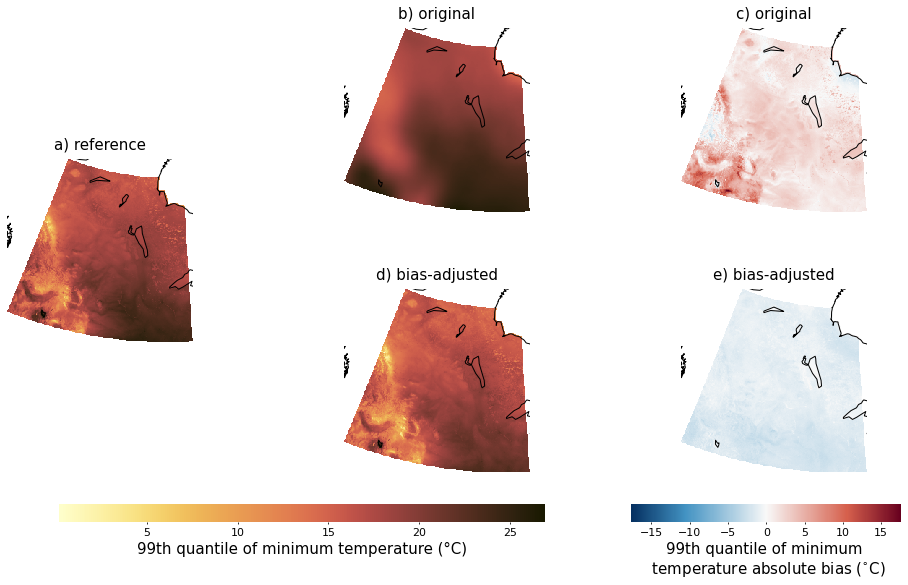

In [25]:
option_id ='CMIP6_ScenarioMIP_MIROC_MIROC6_ssp370_r1i1p1f1_global'
option_region = 'Nelson-Churchill'
option_var = 'q99_tasmin'
fig, axs, cbs=maps(option_id=option_id, option_region=option_region, option_var=option_var)
cbs[1].set_label("99th quantile of minimum \n temperature absolute bias "+r"($^{\circ}$C)")
plt.savefig(f"q99_tasmin_Nelson-Churchill.png", bbox_inches='tight')

In [17]:
from matplotlib import gridspec
plt.savefig(f"q99_tasmin_Nelson-Churchill.png", bbox_inches='tight')


--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:142: UserWarning: Attribute "long_name" not found.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:142: UserWarning: Attribute "long_name" not found.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:142: UserWarning: Attribute "long_name" not found.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:142: UserWarning: Attribute "long_name" not found.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:142: UserWarning: Attribute "long_name" not found.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:142: UserWarning: Attribute "long_name" not found.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:142: UserWarning: Attribute "long_name" not found.
/exec/jlavoie/.conda/espo-g/lib/py

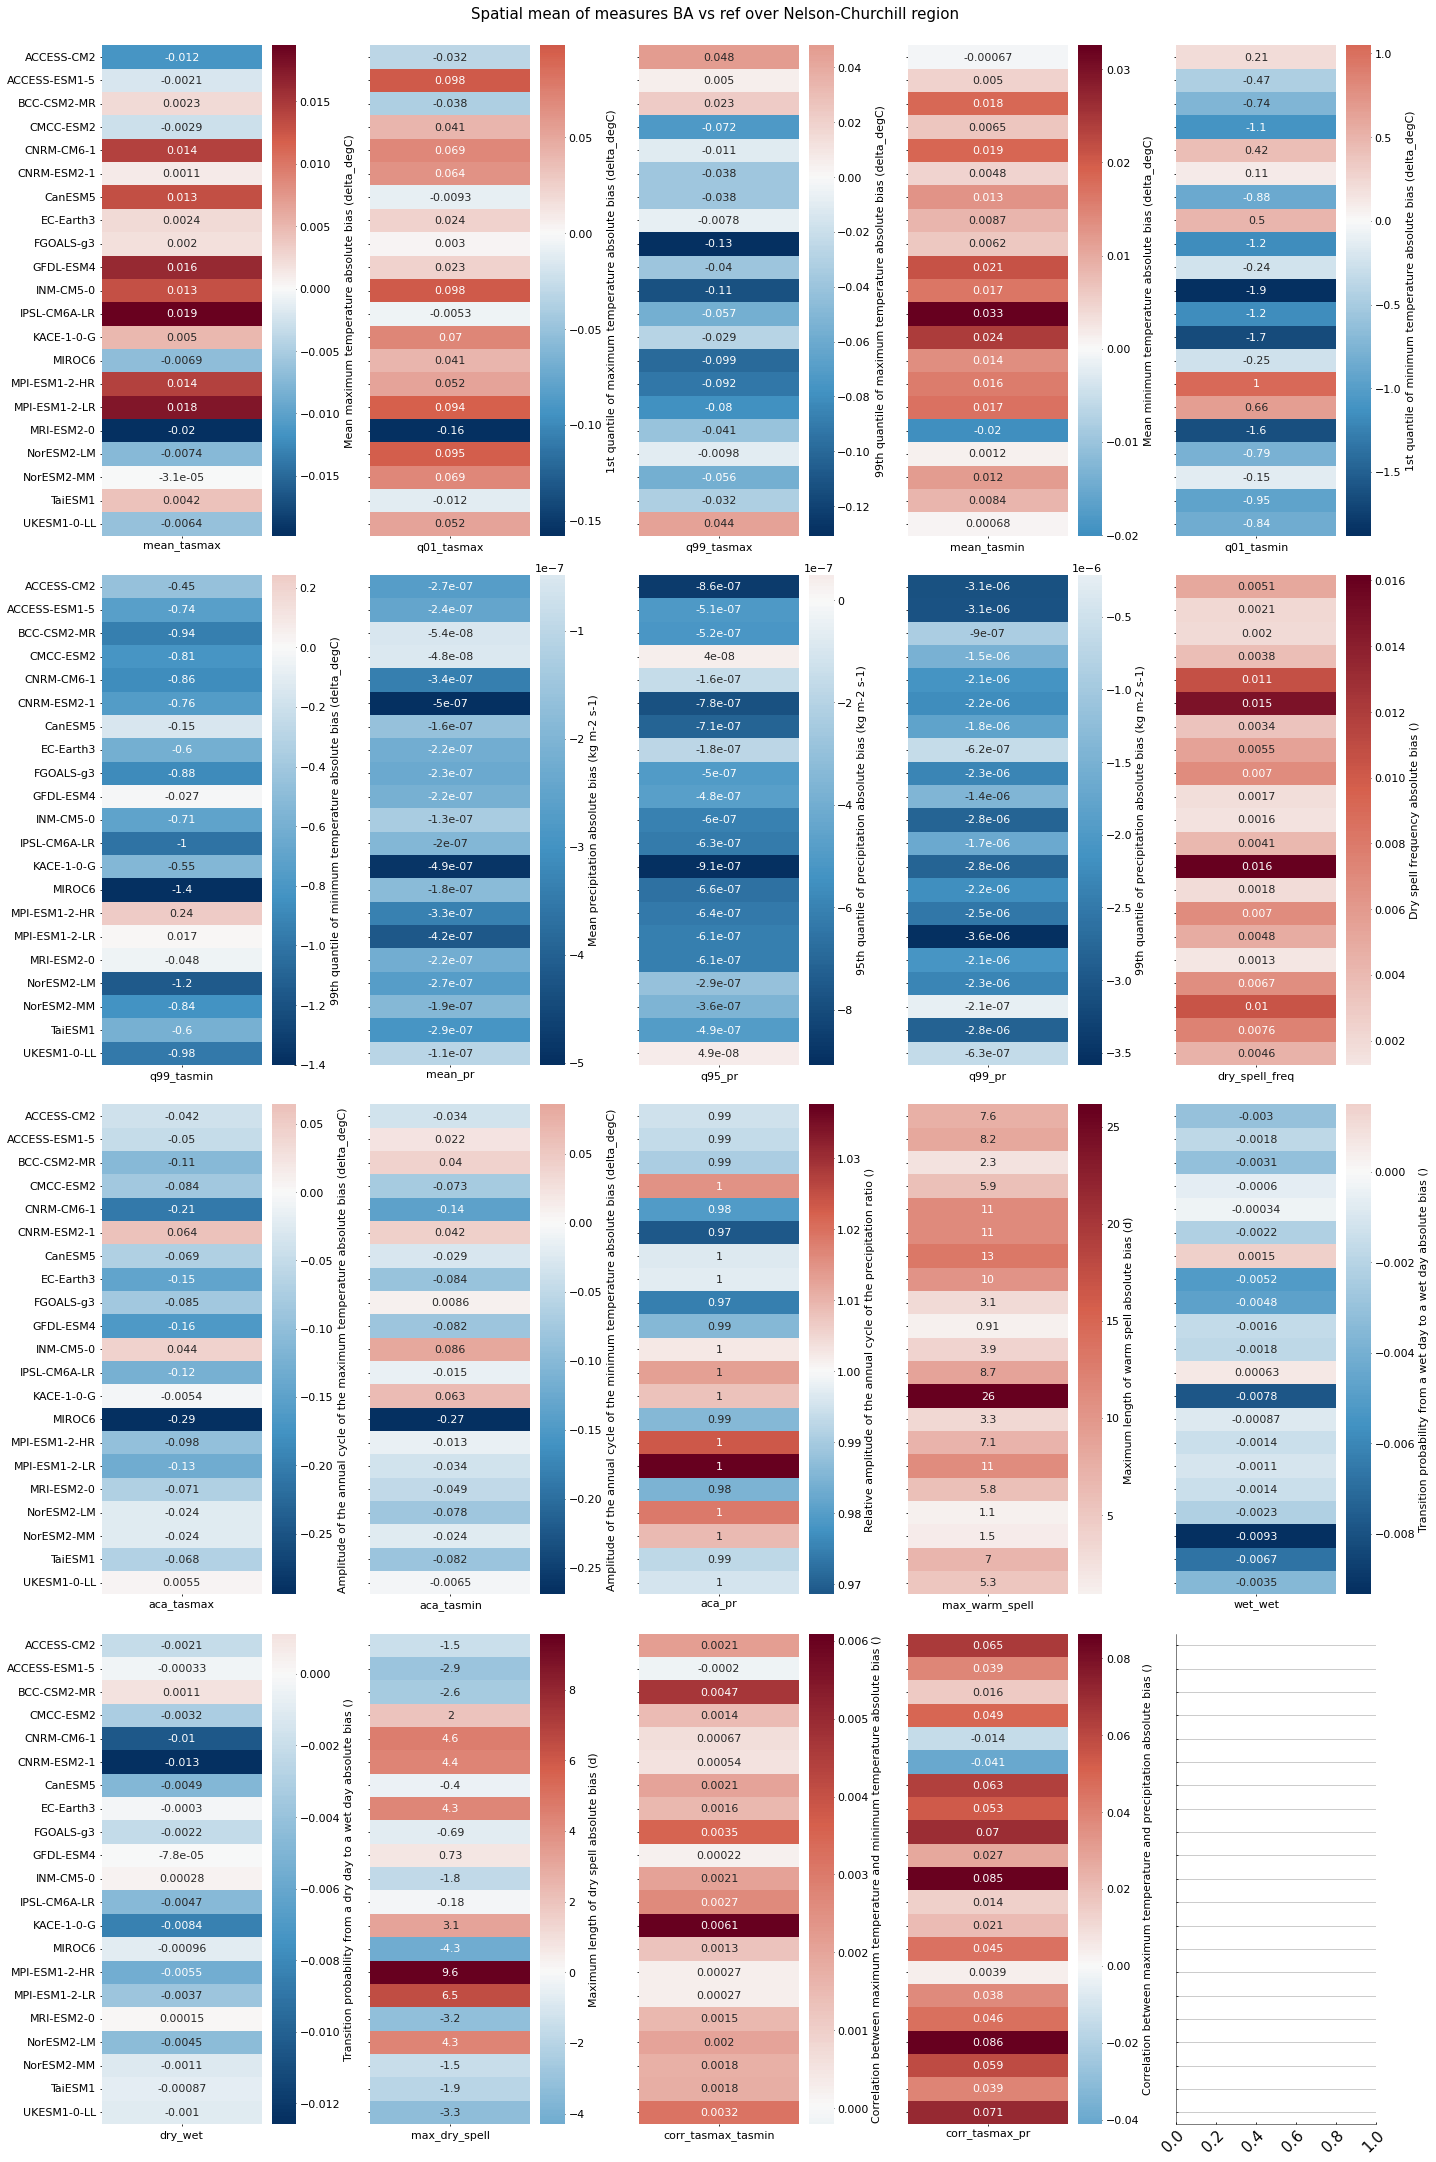

In [60]:
# spatially averaged measures heatmap
dict_meas = pcat.search(processing_level='off-diag-scen-meas', domain= 'Nelson-Churchill', experiment='ssp370').to_dataset_dict()
dict_meas= {ds.attrs['cat:source']:ds for name,ds in dict_meas.items()}


#get labels for cbar
ds_m=dict_meas['EC-Earth3']
ds_m=ds_m[order]

labels={}
for i,var in enumerate(ds_m.data_vars):
    labels[better_name[i]]=f"{ds_m[var].attrs['long_name']} ({ds_m[var].attrs['units']})"

means= np.zeros((21,19))
for i,(id, ds) in enumerate(dict_meas.items()):
    for j, var in enumerate(ds.data_vars):
        means[i,j]= ds[var].mean().values
        
ds_merge = xr.Dataset(data_vars= dict(mean_bias = (['realization','properties'],means)),
                      coords={
                          'realization':(['realization'],list(dict_meas.keys())),
                          'properties': (['properties'],list(ds.data_vars))
                      }              
                     )


# select the right order
# ordered list of properties
order = [
        'mean_tasmax','q01_tasmax', 'q99_tasmax', 'mean_tasmin','q01_tasmin','q99_tasmin',
    'mean_pr','q95_pr','q99_pr','dry_spell_freq', 
    'aca_tasmax', 'aca_tasmin','aca_pr',
         'maximum_length_of_warm_spell','wet_wet_transition', 'dry_wet_transition', 'maximum_length_of_dry_spell',
        'corr_tasmax_tasmin','corr_tasmax_pr',
        ]
# name I want to show up on plot
better_name = [
        'mean_tasmax','q01_tasmax', 'q99_tasmax', 'mean_tasmin','q01_tasmin','q99_tasmin',
    'mean_pr','q95_pr','q99_pr','dry_spell_freq', 
    'aca_tasmax', 'aca_tasmin','aca_pr',
         'max_warm_spell','wet_wet', 'dry_wet', 'max_dry_spell',
        'corr_tasmax_tasmin','corr_tasmax_pr',
        ]
# put in the right order
ds_merge= ds_merge.sel(properties=order, realization = np.sort(ds_merge.realization.values))
# change the name
ds_merge['properties']=better_name

fig, axs = plt.subplots(4,5, figsize=(20,30), sharey=True)
axs= axs.ravel()

for i,p in enumerate(ds_merge.properties.values):
    ax=sp.heatmap(ds_merge.sel(properties=(p)).expand_dims('properties').transpose(),
                  ax=axs[i],
                  plot_kw={'cbar_kws':{'label':labels[p]},
                           'annot':True,
                          },
                 divergent= 1 if 'ratio' in labels[p] else 0,
                 cmap = 'temp_div')
    axs[i].set_xlabel("") # get rid of labels
    axs[i].set_ylabel("")
    plt.xticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
fig.suptitle("Spatial mean of measures BA vs ref over Nelson-Churchill region", fontsize= 15, y =1)
fig.tight_layout()
    


--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:142: UserWarning: Attribute "long_name" not found.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:142: UserWarning: Attribute "long_name" not found.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:142: UserWarning: Attribute "long_name" not found.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:142: UserWarning: Attribute "long_name" not found.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:142: UserWarning: Attribute "long_name" not found.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:142: UserWarning: Attribute "long_name" not found.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:142: UserWarning: Attribute "long_name" not found.
/exec/jlavoie/.conda/espo-g/lib/py

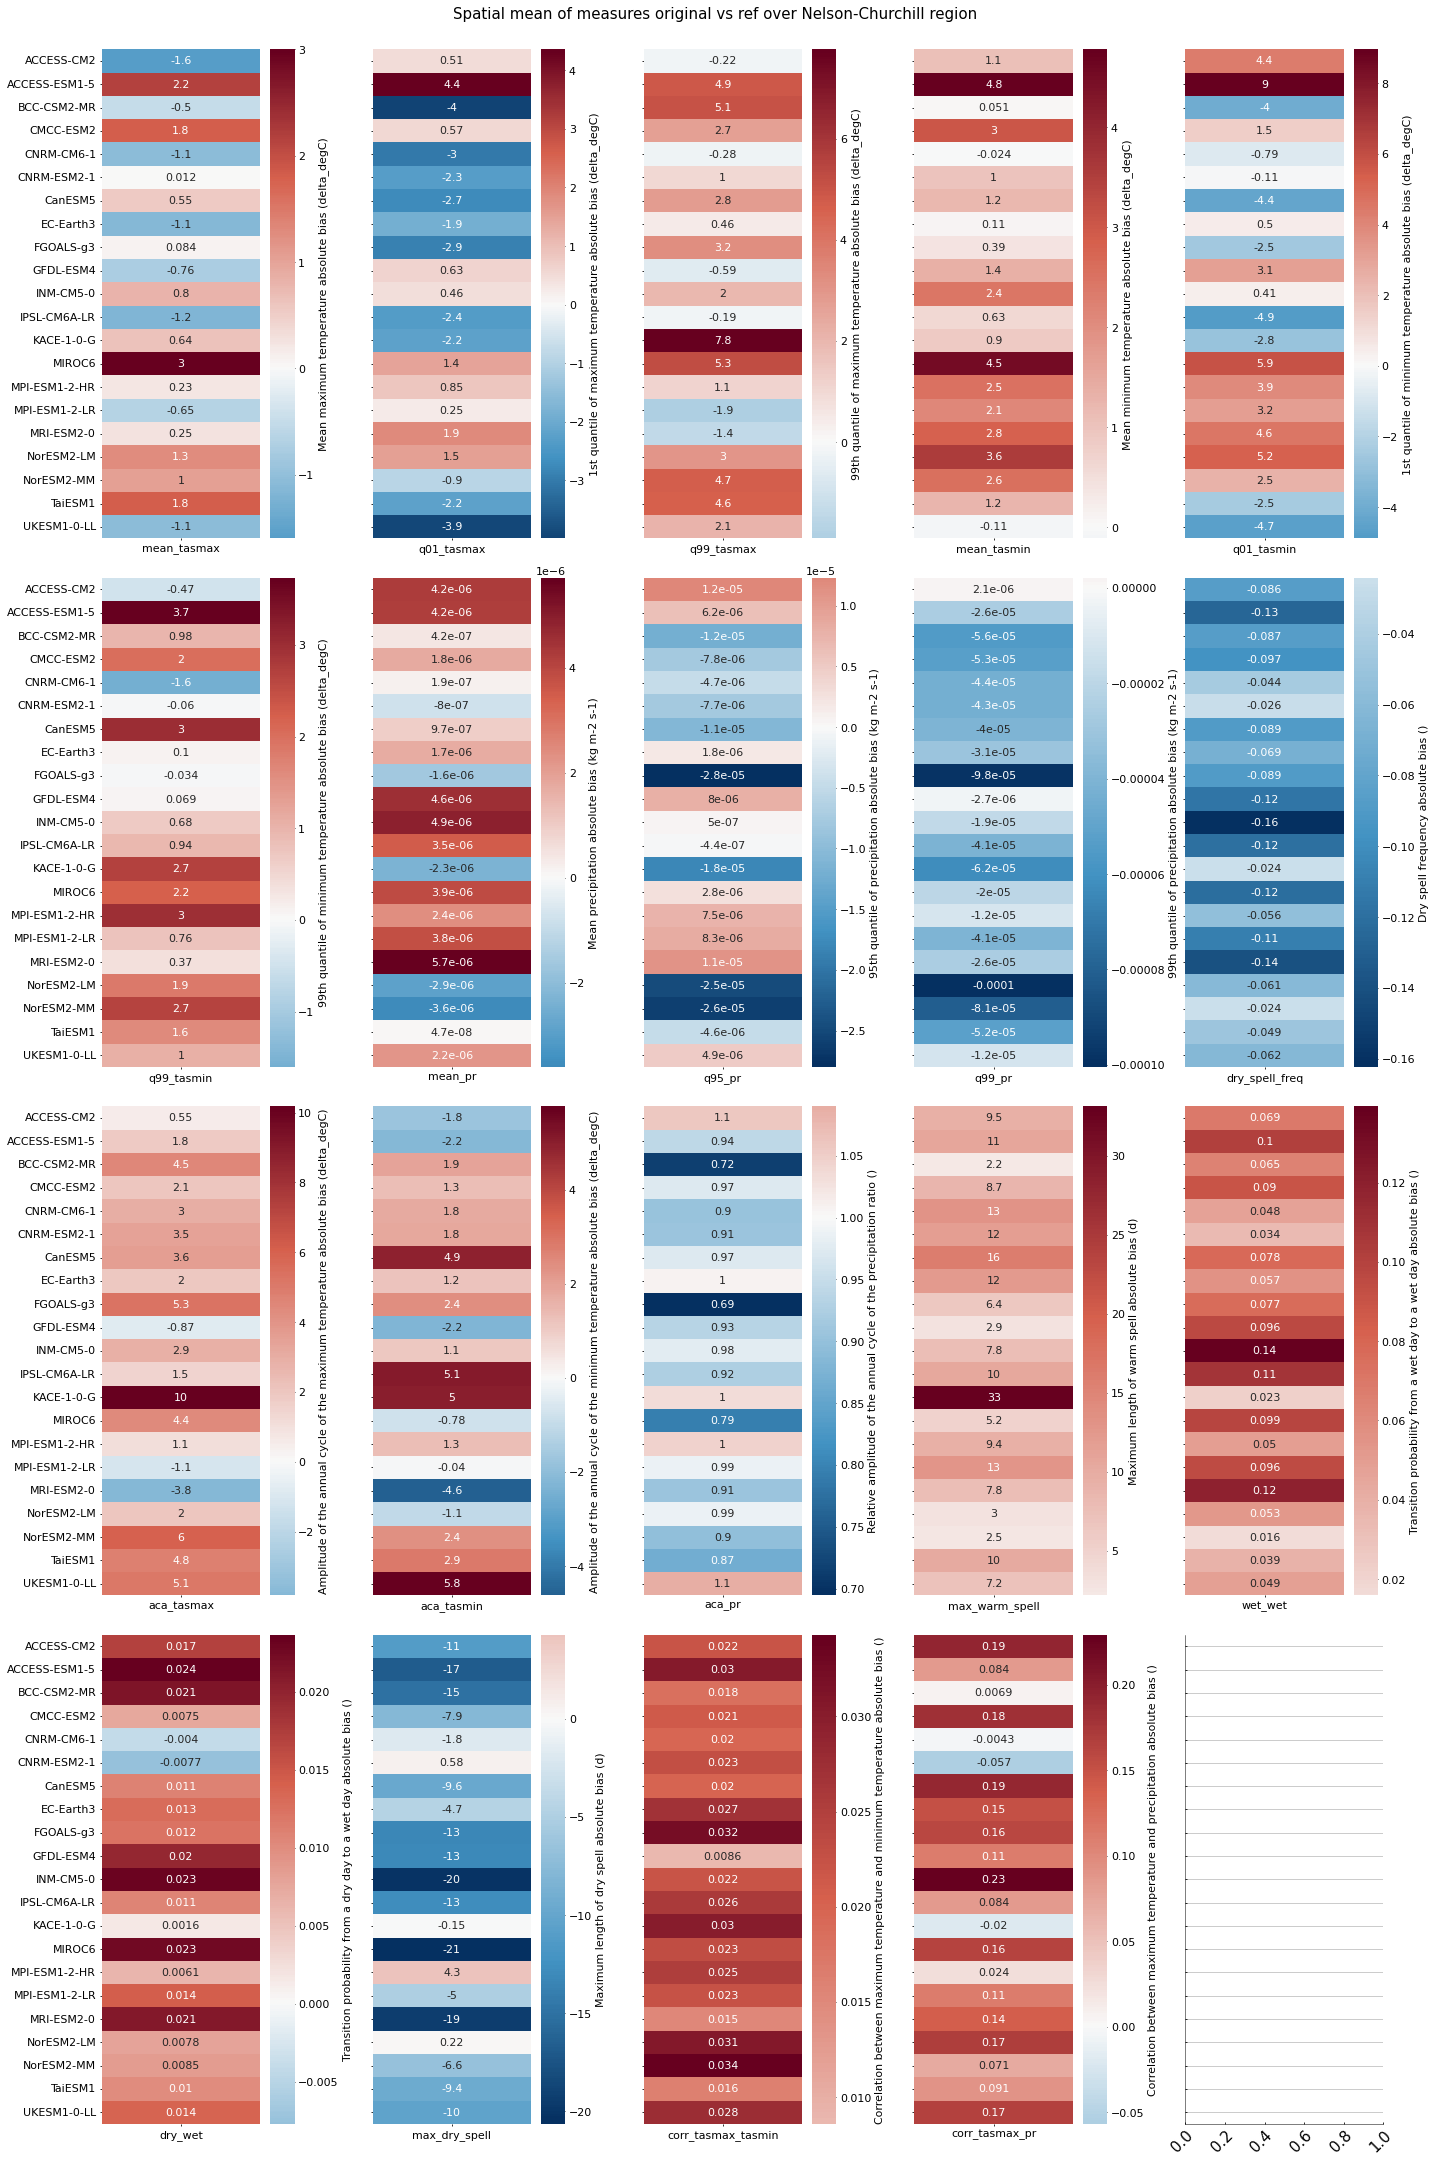

In [61]:
# spatially averaged measures heatmap
dict_meas = pcat.search(processing_level='off-diag-sim-meas', domain= 'Nelson-Churchill', experiment='ssp370').to_dataset_dict()
dict_meas= {ds.attrs['cat:source']:ds for name,ds in dict_meas.items()}


#get labels for cbar
ds_m=dict_meas['EC-Earth3']
ds_m=ds_m[order]

labels={}
for i,var in enumerate(ds_m.data_vars):
    labels[better_name[i]]=f"{ds_m[var].attrs['long_name']} ({ds_m[var].attrs['units']})"

means= np.zeros((21,19))
for i,(id, ds) in enumerate(dict_meas.items()):
    for j, var in enumerate(ds.data_vars):
        means[i,j]= ds[var].mean().values
        
ds_merge = xr.Dataset(data_vars= dict(mean_bias = (['realization','properties'],means)),
                      coords={
                          'realization':(['realization'],list(dict_meas.keys())),
                          'properties': (['properties'],list(ds.data_vars))
                      }              
                     )


# select the right order
# ordered list of properties
order = [
        'mean_tasmax','q01_tasmax', 'q99_tasmax', 'mean_tasmin','q01_tasmin','q99_tasmin',
    'mean_pr','q95_pr','q99_pr','dry_spell_freq', 
    'aca_tasmax', 'aca_tasmin','aca_pr',
         'maximum_length_of_warm_spell','wet_wet_transition', 'dry_wet_transition', 'maximum_length_of_dry_spell',
        'corr_tasmax_tasmin','corr_tasmax_pr',
        ]
# name I want to show up on plot
better_name = [
        'mean_tasmax','q01_tasmax', 'q99_tasmax', 'mean_tasmin','q01_tasmin','q99_tasmin',
    'mean_pr','q95_pr','q99_pr','dry_spell_freq', 
    'aca_tasmax', 'aca_tasmin','aca_pr',
         'max_warm_spell','wet_wet', 'dry_wet', 'max_dry_spell',
        'corr_tasmax_tasmin','corr_tasmax_pr',
        ]
# put in the right order
ds_merge= ds_merge.sel(properties=order, realization = np.sort(ds_merge.realization.values))
# change the name
ds_merge['properties']=better_name

fig, axs = plt.subplots(4,5, figsize=(20,30), sharey=True)
axs= axs.ravel()
for i,p in enumerate(ds_merge.properties.values):
    ax=sp.heatmap(ds_merge.sel(properties=(p)).expand_dims('properties').transpose(),
                  ax=axs[i],
                  plot_kw={'cbar_kws':{'label':labels[p]},
                           'annot':True},
                 divergent= 1 if 'ratio' in labels[p] else 0,
                 cmap = 'temp_div')
    axs[i].set_xlabel("") # get rid of labels
    axs[i].set_ylabel("")
    plt.xticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
fig.suptitle("Spatial mean of measures original vs ref over Nelson-Churchill region", fontsize= 15, y =1)
fig.tight_layout()
    